Epoch 1/5 [Val]: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


Epoch 1/5 - Train Loss: 233.4215, Train Acc: 77.70% - Val Loss: 1.7555, Val Acc: 94.80%


Epoch 2/5 [Val]: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Epoch 2/5 - Train Loss: 51.5801, Train Acc: 93.75% - Val Loss: 1.3598, Val Acc: 96.40%


Epoch 3/5 [Val]: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Epoch 3/5 - Train Loss: 35.4994, Train Acc: 95.41% - Val Loss: 1.1902, Val Acc: 97.20%


Epoch 4/5 [Val]: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Epoch 4/5 - Train Loss: 25.6996, Train Acc: 96.80% - Val Loss: 1.6348, Val Acc: 96.40%


Epoch 5/5 [Val]: 100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Epoch 5/5 - Train Loss: 18.2229, Train Acc: 97.68% - Val Loss: 1.3876, Val Acc: 97.20%


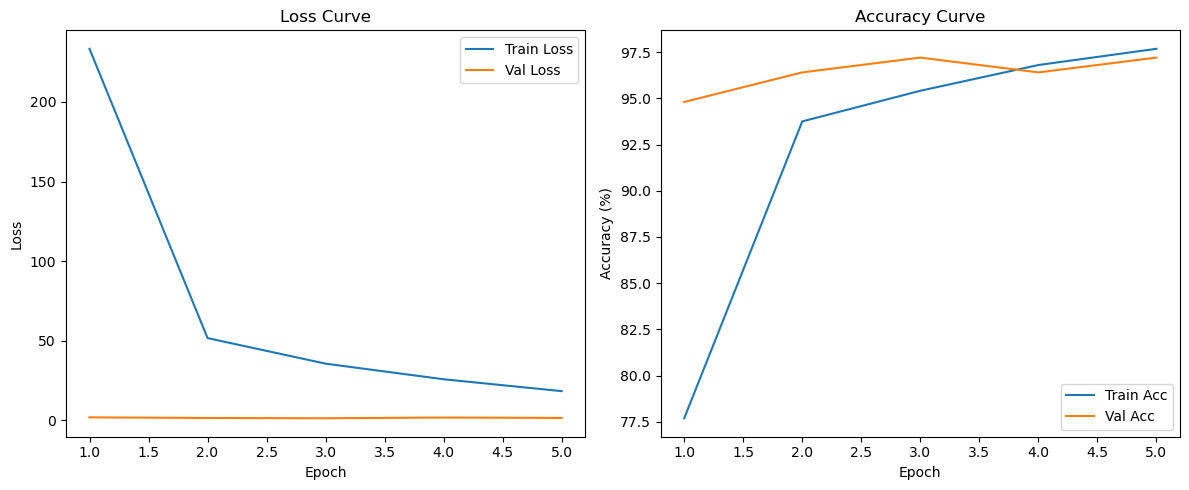


✅ Test Accuracy (EfficientNet-B0 + Partial FT + Reg): 98.40%

📊 Classification Report:
                           precision    recall  f1-score   support

     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       0.83      1.00      0.91         5
        BLACK RUSTIC MOTH       1.00      1.00      1.00         5
             BLAIRS MOCHA       1.00      1.00      1.00         5
    BLOTCHED EMERALD MOTH       1.00      1.00      1.00         5
BLUE BORDERED CARPET MOTH       1.00      1.00      1.00         5
            CINNABAR MOTH       1.00      1.00      1.00         5
           CLEARWING MOTH       1.00      0.80      0.89         5
               COMET MOTH       1.00      1.00      1.00         5
    DEATHS HEAD HAWK MOTH       1.00      1.00      1.00         5
       ELEPHANT HAWK MOTH       1.00    

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths 
dataset_path = Path("../data/kaggle-dataset/archive")
train_path = dataset_path / "train"
val_path = dataset_path / "valid"
test_path = dataset_path / "test"

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets and loaders
train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

num_classes = len(train_dataset.classes)
class_names = train_dataset.classes

# Load pretrained EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)

# Partial fine-tuning: unfreeze last block and classifier
for name, param in model.named_parameters():
    if "features.6" in name or "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Modify classifier
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.classifier[1].in_features, num_classes)
)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)

# Track history
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"- Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    


# Plot Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Train Acc")
plt.plot(range(1, epochs + 1), val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate on Test Set
# Evaluate on Test Set
model.eval()
all_preds = []
all_labels = []
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

# ✅ Print Test Accuracy
test_acc = 100 * test_correct / test_total
print(f"\n✅ Test Accuracy (EfficientNet-B0 + Partial FT + Reg): {test_acc:.2f}%")

                
# Classification report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Show confused pairs only
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)
confused_indices = np.argwhere(cm_no_diag > 0)

print("\n🔍 Confused Class Pairs:")
for i, (true_idx, pred_idx) in enumerate(confused_indices):
    count = cm[true_idx][pred_idx]
    print(f"{i+1}. True: {class_names[true_idx]}  ↔  Predicted: {class_names[pred_idx]}  ({count} times)")


Here are the loss and accuracy plots for the EfficientNet-B0 model:

📈 Interpretation:
Training Accuracy & Loss: Training accuracy steadily improves, and loss decreases, suggesting good learning.

Validation Accuracy & Loss: Validation accuracy is high and relatively stable, while validation loss fluctuates slightly but does not show a steep increase.

✅ Overfitting Check:
There’s no strong evidence of overfitting. The validation accuracy keeps up with the training accuracy, and the loss gap is small.


🔍 Confusion: True Label = 'CLEARWING MOTH' ↔ Predicted as = 'HUMMING BIRD HAWK MOTH'


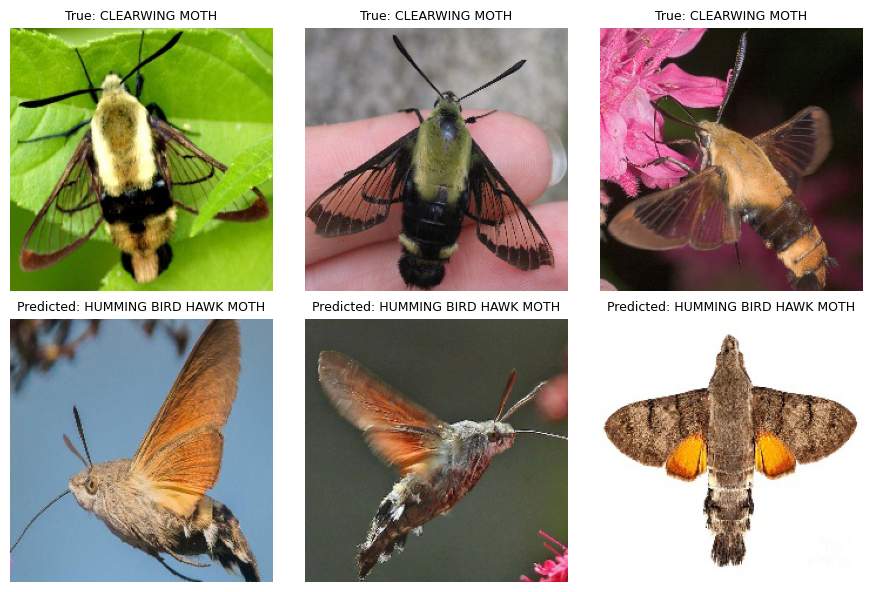


🔍 Confusion: True Label = 'EMPEROR GUM MOTH' ↔ Predicted as = 'EMPEROR MOTH'


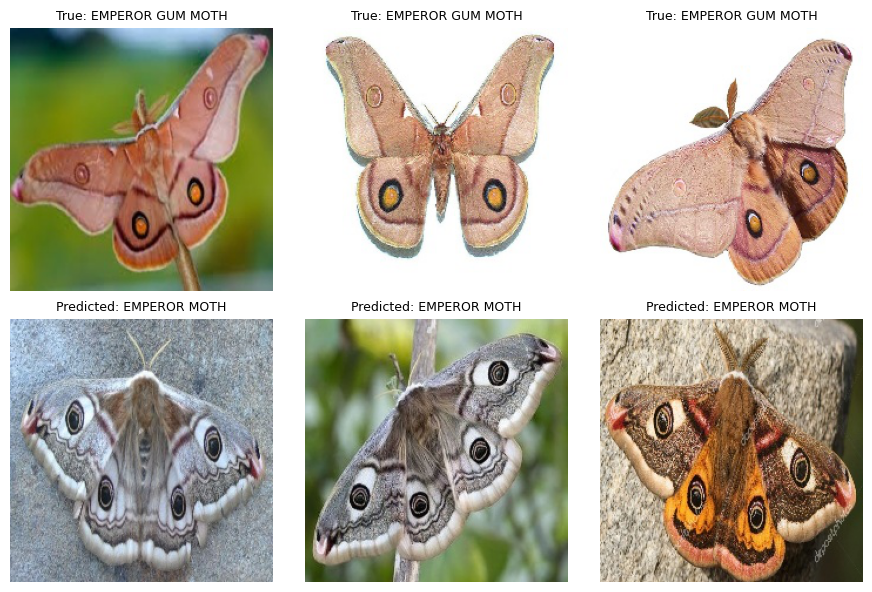


🔍 Confusion: True Label = 'MUSLIN MOTH' ↔ Predicted as = 'BIRD CHERRY ERMINE MOTH'


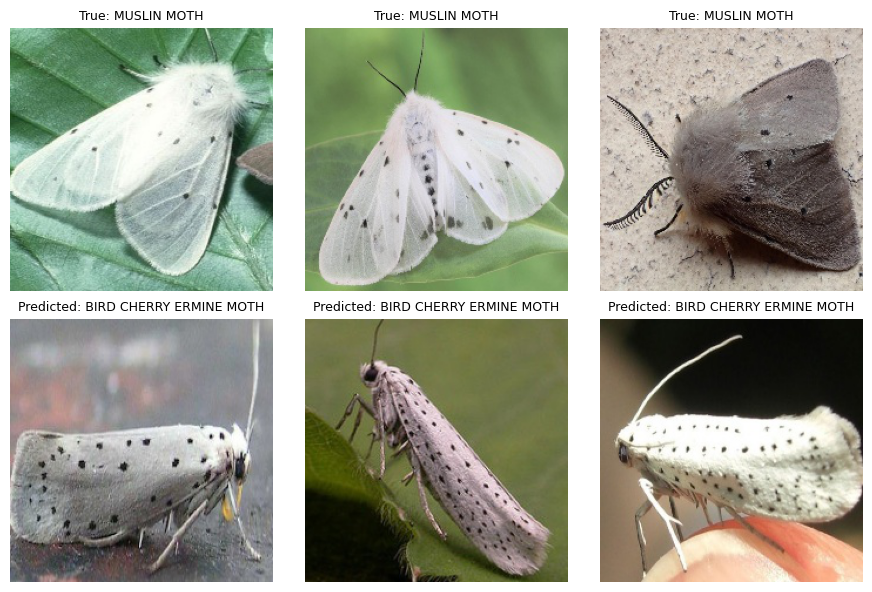

In [8]:
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import random

def show_confused_pairs(dataset_path, confused_pairs, samples_per_class=3):
    """
    Visualize sample images of confused species pairs side by side.

    Parameters:
        dataset_path (Path or str): Root path to dataset containing 'test' folder.
        confused_pairs (list of tuples): List of (true_species, predicted_species).
        samples_per_class (int): Number of images to show per species.
    """
    test_path = Path(dataset_path) / "test"

    for true_species, pred_species in confused_pairs:
        true_dir = test_path / true_species
        pred_dir = test_path / pred_species

        true_images = list(true_dir.glob("*"))
        pred_images = list(pred_dir.glob("*"))

        # Pick random sample images or fewer if not enough
        true_samples = random.sample(true_images, min(samples_per_class, len(true_images)))
        pred_samples = random.sample(pred_images, min(samples_per_class, len(pred_images)))

        print(f"\n🔍 Confusion: True Label = '{true_species}' ↔ Predicted as = '{pred_species}'")

        fig, axes = plt.subplots(2, samples_per_class, figsize=(samples_per_class * 3, 6))

        for i in range(samples_per_class):
            # True species images on first row
            if i < len(true_samples):
                img = Image.open(true_samples[i])
                axes[0, i].imshow(img)
                axes[0, i].set_title(f"True: {true_species}", fontsize=9)
            axes[0, i].axis('off')

            # Predicted species images on second row
            if i < len(pred_samples):
                img = Image.open(pred_samples[i])
                axes[1, i].imshow(img)
                axes[1, i].set_title(f"Predicted: {pred_species}", fontsize=9)
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

# 🔁 EfficientNet-B0 confused pairs
confused_pairs_effnet = [
    ("CLEARWING MOTH", "HUMMING BIRD HAWK MOTH"),
    ("EMPEROR GUM MOTH", "EMPEROR MOTH"),
    ("MUSLIN MOTH", "BIRD CHERRY ERMINE MOTH"),
]

dataset_path = Path("../data/kaggle-dataset/archive")

# 👀 Run visualisation for EfficientNet-B0 confused pairs
show_confused_pairs(dataset_path, confused_pairs_effnet)
